## BENCHMARKING PWMs and SVMs for TFBS PREDICTION: LINEPLOT

In [56]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from dataclasses import dataclass

In [60]:
@dataclass
class LineplotArgs():
    lengths: tuple = ('est_lmer', 'gkm', 'gapped_kmer', 'gkmrbf')
    optimal: bool = False
    mapping_path: str = "Data_SHUFFLE/dataset_size_comparison_shuffle/dbd_exp_mapping.tsv" #"path/to/dbd_exp_mapping_file"
    tools: tuple = ("svm")
    background : str = "dnase"
    analysis: str = "k"
    metrics: tuple = ("AUPRC")
    data_dir: str = "Data_DNASE/svm-kernel-comparison"
    output_dir: str = "provalisco"
    formats: tuple = ("png")

In [61]:
def args_ds(length, metric = None, tool = None):
    return f"summary_table_size_{length}.tsv", f"{metric}_{tool}_size_{length}"

def args_sw(length, optimal, metric = None, tool = None):
    optimal = "optimal" if optimal else "full"
    return f"summary_table_{optimal}_width_{length}.tsv", f"{metric}_{tool}_{optimal}_width_{length}"
   
def args_k(kernel, optimal, metric = None, tool = None):
   optimal = "optimal" if optimal else "full"
   return f"summary_table_{optimal}_{kernel}.tsv", f"{metric}_{tool}_{optimal}_{kernel}"
   

def add_DBD_column(args: LineplotArgs):
    """
    Adds a DNA Binding Domain (DBD) column to summary tables for given dataset sizes.

    Parameters:
    - lengths: List of dataset sizes (e.g., [50, 100, 200, '0']), sequence widths or kernels.
    - path_to_tsv: Path to the TSV file containing the mapping of experiments to DBDs.
    - analysis: Type of analysis (e.g. "ds(=dataset size)", "sw(=sequence width)", "k(=kernel)")
    - optimal: Boolean value that is True when provided, False otherwise.

    This function reads summary tables for each dataset size, adds a column indicating
    the DBD for each experiment based on the mapping file, and saves the updated tables
    as new files.
    """
    dbd_exp_map = pd.read_csv(args.mapping_path, sep = "\t")

    for length in args.lengths:
        
        if args.analysis == "sw":
            input_filename, _ = args_sw(length, args.optimal)
        elif args.analysis == "ds":
            input_filename, _ = args_ds(length)
        elif args.analysis == "k":
            input_filename, _ = args_k(length, args.optimal)
        else:
           raise ValueError("analysis must be one of the following ['sw', 'ds', 'k']")
        
        bn, ext = os.path.splitext(input_filename)
        output_filename = bn + "_with_dbd" + ext
        
        input_path = os.path.join(args.data_dir, input_filename)
        output_path = os.path.join(args.data_dir, output_filename)

        df = pd.read_csv(input_path, sep = "\t")
        
        # Add DBD column by mapping experiments to their corresponding DBD
        df["DBD"] = df["EXPERIMENT"].map(
            lambda exp: dbd_exp_map.loc[dbd_exp_map["Experiment"] == exp, "DBD"].iloc[0]
        )

        # Save the updated DataFrame
        df.to_csv(output_path, sep = '\t', index = False)


def retrieve_lineplot_data(tool, metric, args):
  """
  Retrieves and processes data for a given tool and metric.

  Parameters:
  - lengths: List of hues to cycle on (e.g., ['500', '1000', '2000', '5000', '10000', '0' (=full)]).
  - tool: The tool being analyzed (e.g., 'svm').
  - metric: The metric to be analyzed (e.g., 'AUPRC').

  Returns:
  - A DataFrame with the processed data containing columns:
    ["DBD", metric, "Hue"].
  """

  df_mean = pd.DataFrame(columns = ["DBD", metric, "HUE"])
  for length in args.lengths:
    if args.analysis == "sw":
        input_filename, col = args_sw(length, args.optimal, metric, tool)
    elif args.analysis == "ds":
        input_filename, col = args_ds(length, metric, tool)
    elif args.analysis == "k":
        input_filename, col = args_k(length, args.optimal, metric, tool)
    else:
        raise ValueError("analysis must be one of the following ['sw', 'ds', 'k']")
    
    bn, ext = os.path.splitext(input_filename)
    input_filename = bn + "_with_dbd" + ext
    file_path = os.path.join(args.data_dir, input_filename)

    df = pd.read_csv(file_path, sep = '\t')

    # Aggregate mean values of the metric for each DBD
    df_conc = (
                df[["EXPERIMENT", col, "DBD"]]
                .groupby("DBD")[col]
                .mean()
                .to_frame()
                .reset_index()
            )
    df_conc.columns = ["DBD", metric]
    df_conc["HUE"] = length
    
    df_mean = pd.concat([df_mean, df_conc], ignore_index=True)

  df_mean["HUE"] = df_mean["HUE"].replace("0", "full")

  return df_mean

def create_lineplot(df, tool, metric, format, output_dir, analysis, background):
    """
    Creates and saves an inverted line plot for the given data, tool, and metric.

    Parameters:
    - df: DataFrame containing the data to plot
    - tool: Name of the tool being analyzed ('meme', 'streme' or 'svm')
    - metric: Metric to be plotted on the y-axis ('AUPRC', 'AUROC', 'F1')
    - format: Define the format(s) to save the plot (e.g. 'png', 'svg')
    """

    fig = plt.figure(figsize=(25, 15))
    sns.set_theme(style="whitegrid")
    
    colors = ["#e27c7c", "#a86464", "#6d4b4b", "#333333", "#466964", "#599e94"]

    ax = sns.lineplot(
        data=df,
        x="DBD",
        y=metric,
        hue="HUE",
        marker="o",
        dashes="",
        linewidth=1,
        markersize=10,
        legend=True,
        palette=colors
    )

    sns.set_style("whitegrid", {'axes.grid': False})
    title_prefix = "ls-gkm" if tool == 'svm' else tool
    plt.title(f"{metric} {title_prefix} grouped by DBD", fontsize=50)
    plt.ylabel(metric, fontsize=40)
    plt.xlabel("DNA Binding Domain", fontsize=40)
    plt.ylim(0, 1)

    ax.tick_params(axis='x', labelsize=30, rotation=90)
    ax.tick_params(axis='y', labelsize=30)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    sns.move_legend(ax, "upper right", bbox_to_anchor=(1, 0.4), ncol=2)

    output_base = f"{output_dir}/{tool}_{metric}_grouped_by_DBD_{analysis}_{background}"
    outfig = ax.get_figure()
    
    if "svg" in format:
        outfig.savefig(f"{output_base}.svg", dpi=300, format='svg', bbox_inches="tight")
    if "png" in format:
        outfig.savefig(f"{output_base}.png", dpi=300, bbox_inches="tight")
    
    plt.show()

def save_all_lineplots(args: LineplotArgs):
   for tool in args.tools:
      for metric in args.metrics:
         create_lineplot(
                    retrieve_lineplot_data(tool, metric, args),
                    tool,
                    metric,
                    args.formats,
                    args.output_dir,
                    args.analysis,
                    args.background
                )
        

def lineplot(args: LineplotArgs):
    if isinstance(args.tools, str):
       args.tools = [args.tools]
    if isinstance(args.lengths, str):
       args.lengths = [args.lengths]
    if isinstance(args.metrics, str):
       args.metrics = [args.metrics]
    if not(isinstance(args.formats, list)):
       args.formats = [args.formats]
       
    add_DBD_column(args)
    save_all_lineplots(args)

C:\Users\alisa\AppData\Local\Temp\ipykernel_35216\4076607329.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_mean = pd.concat([df_mean, df_conc], ignore_index=True)
C:\Users\alisa\AppData\Local\Temp\ipykernel_35216\4076607329.py:121: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  ax = sns.lineplot(


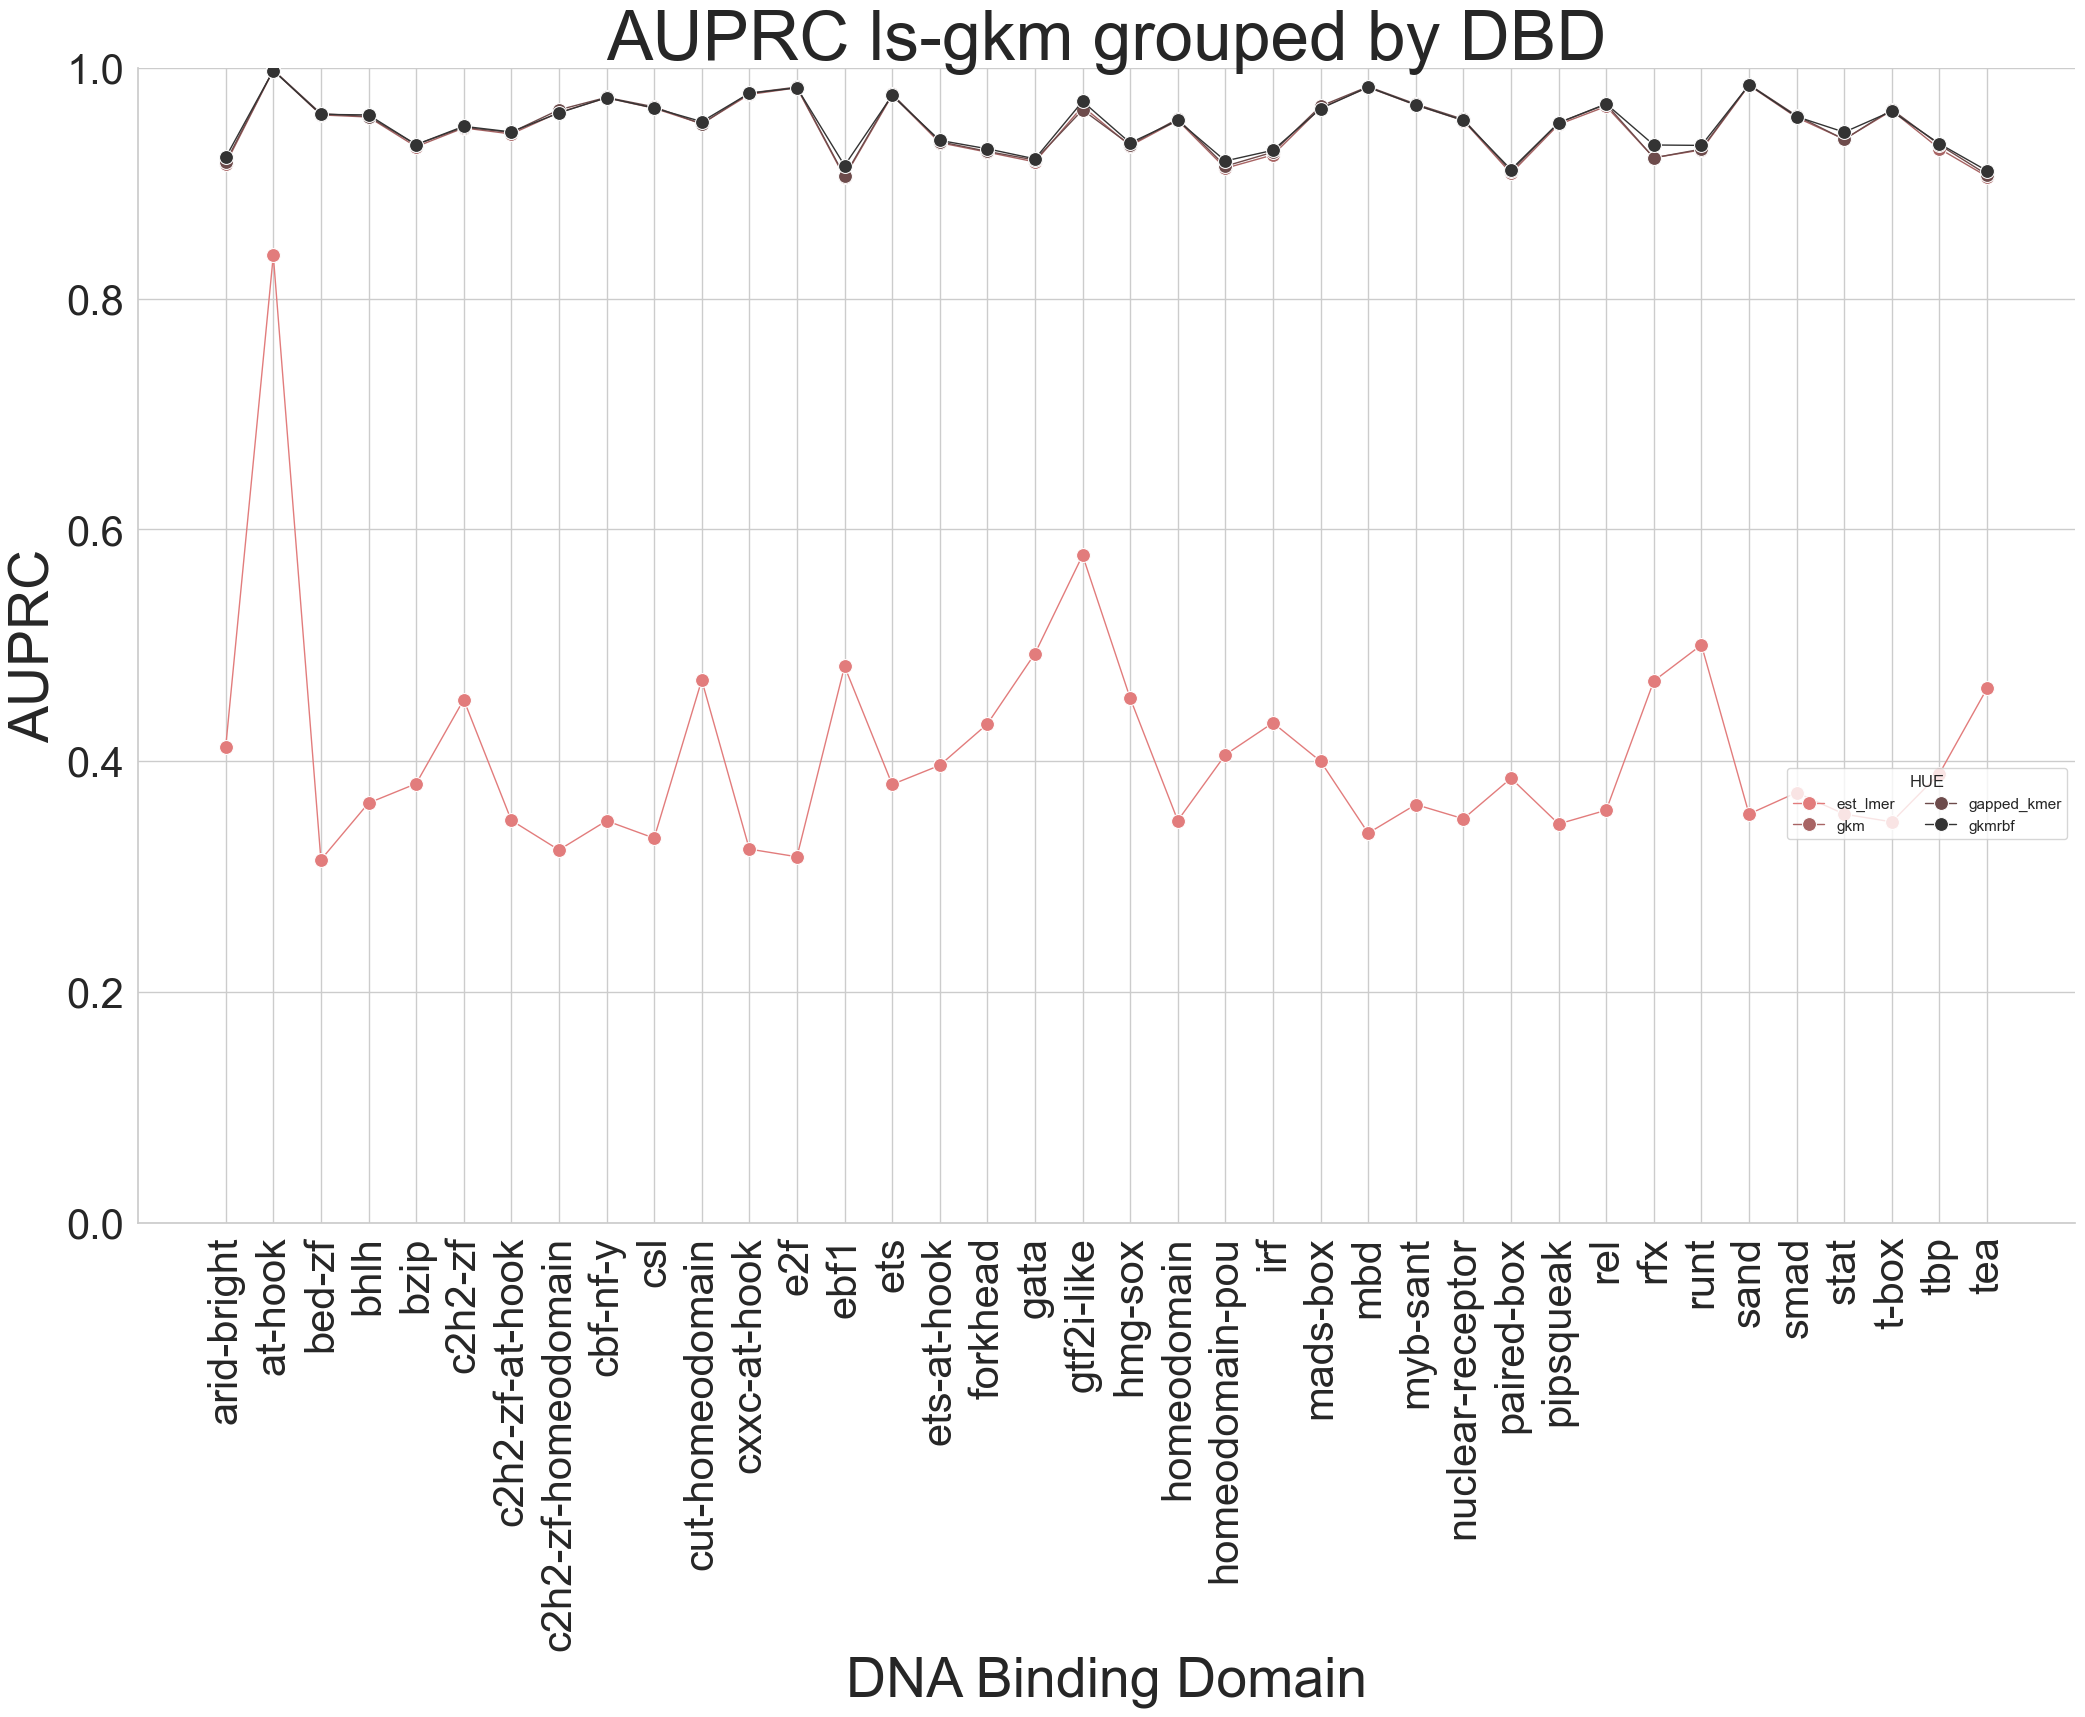

In [62]:
args_lineplot = LineplotArgs()
lineplot(args_lineplot)